In [270]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data
events_data = pd.read_csv('data\events_data.csv')
subscribers_data = pd.read_csv('data\subscribers_data.csv')

# Remove unnnecesary colums
subscribers_data = subscribers_data.drop(columns=['weeks_from_subscription_start'])

# Handle missing values
events_data.fillna(0, inplace=True)
subscribers_data.fillna(0, inplace=True)

# Convert date fields
events_data['dt'] = pd.to_datetime(events_data['dt'])
subscribers_data['effective_date'] = pd.to_datetime(subscribers_data['effective_date'])

# Sort Events data by date
events_data.sort_values(by='dt', inplace=True)

# Sort Subscribers data by date
subscribers_data.sort_values(by='effective_date', inplace=True)


In [271]:
from datetime import datetime, timedelta

# Convert the 'dt' column to datetime format
events_data['dt'] = pd.to_datetime(events_data['dt'], format='%d-%m-%y')

# Specify the specific date from which you want to count activities
specific_date = datetime(2021, 7, 9)

# Specify the duration for which you want to count pt_sale events (in this case, 3 months)
duration = timedelta(days=90)

# Identify the unique member_id in the week following the specific date
week_start = specific_date + timedelta(days=7)
week_end = week_start + timedelta(days=6)
unique_members_in_week = events_data[(events_data['dt'] >= week_start) & (events_data['dt'] <= week_end)]['member_id'].unique()

# Filter data based on the specific date and the identified members
filtered_df = events_data[(events_data['dt'] >= (specific_date - duration)) & (events_data['member_id'].isin(unique_members_in_week))]

# Define the event types
event_types = ['app_interaction', 'personal_appointment_scheduled', 'human_communication_event',
               'sms_sent', 'chat_message_sent', 'manual_email_sent', 'automated_email_sent',
               'fitness_consoltation', 'usage']

# Create a new DataFrame to store the results
result_df = pd.DataFrame(index=unique_members_in_week)

# Iterate over each event type
for event_type in event_types:
    # Count occurrences of each event type for each member_id
    event_count = filtered_df[filtered_df['event_type'] == event_type].groupby('member_id').size()
    result_df[f'{event_type}_count'] = result_df.index.map(event_count).fillna(0)

# Calculate if a member had a pt_sale event in the last 3 months (1 for yes, 0 for no)
pt_sale_count = filtered_df[filtered_df['event_type'] == 'pt_sale'].groupby('member_id').size()
result_df['pt_sale'] = result_df.index.map(pt_sale_count).fillna(0)
result_df['pt_sale'] = (result_df['pt_sale'] > 0).astype(int)

# Fill NaN values with 0
result_df = result_df.fillna(0)

# Print the result DataFrame
print(result_df)


                                      app_interaction_count  \
a9492c95-c3c0-47d9-bee6-fb8f66901854                   65.0   
2057153a-bbc9-44dc-87ba-4f4baea74d95                    0.0   
4267b892-6532-4428-83d7-32b040fc52a9                    9.0   
5594f99d-201c-45c4-b6c1-e506c5f3e742                   10.0   
03473e68-8358-4195-baef-d168b6d63c61                  147.0   
...                                                     ...   
2795edd3-d51a-11e3-81f6-0000ac10e365                    0.0   
697634f3-7974-45a7-a60f-a7be080f0be9                    0.0   
106c2691-bddc-4353-ab74-0e282e699b71                    0.0   
f0553306-efe2-4d3d-a460-beb93c44b54e                    0.0   
3c36cfe2-0968-11e2-9ac9-0000ac10e364                    0.0   

                                      personal_appointment_scheduled_count  \
a9492c95-c3c0-47d9-bee6-fb8f66901854                                  24.0   
2057153a-bbc9-44dc-87ba-4f4baea74d95                                  55.0   
4267b892-

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assuming 'result_df' is the DataFrame with counts and pt_sale information

# Filter individuals who have not taken personal training
train_data = result_df

# Prepare features (X) and target variable (y)
X = train_data.drop(columns=['pt_sale'])
y = train_data['pt_sale']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)



# Choose a classification algorithm (Logistic Regression)
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1132
           1       0.26      0.11      0.15        47

    accuracy                           0.95      1179
   macro avg       0.61      0.55      0.56      1179
weighted avg       0.94      0.95      0.94      1179



In [273]:
subscribers_data['effective_date'] = pd.to_datetime(subscribers_data['effective_date'], format='%d-%m-%y')

subscribers_data_for_date = subscribers_data[subscribers_data['effective_date'] == specific_date]

# Make predictions for all individuals who have not taken personal training and have a subscription.
prediction_df = result_df[result_df['pt_sale'] == 0].drop(columns=['pt_sale'])

# Filter prediction_df to include only rows with member_id present in subscribers_data_for_date
prediction_df = prediction_df[prediction_df.index.isin(subscribers_data_for_date['member_id'])]

# Check if there are any rows left after filtering
if not prediction_df.empty:
    # Continue with the predictions
    prediction_df['predicted_probability'] = model.predict_proba(prediction_df)[:, 1]

    # Rank and recommend the top 10 individuals
    top_10_recommendations = prediction_df.sort_values(by='predicted_probability', ascending=False).head(10)

    # Print the top 10 recommendations
    print(top_10_recommendations[['predicted_probability']])
else:
    print("No predictions available for the selected date.")


                                      predicted_probability
d99e3a5f-b5da-4410-9263-cdca38d15283               0.968508
dda10df5-00d9-403d-904a-ce7218d2b46b               0.963072
1d7d91c9-da48-4f86-b1f8-89e2f9990a19               0.943016
29e7fb83-a9cc-47e2-b54f-94679828e520               0.927907
42a95492-1add-4494-a9d4-52feafb29ddd               0.923758
c5077887-74bd-4db3-8314-6fda8a4f729b               0.886046
9c712088-ae18-4881-9b94-ae5cf3f57aa2               0.883306
6b29e842-f2cb-48c7-a575-d840526fb154               0.818834
842e832d-bf74-4624-8ab1-54a4f63d98ae               0.817896
c56613f1-eba3-4755-9fbc-d994df3ab90a               0.811780


In [274]:
# Merge the DataFrames on 'member_id' to add 'predicted_probability' to 'subscribers_data_for_date'
subscribers_data_for_date = subscribers_data_for_date.merge(prediction_df[['predicted_probability']], left_on='member_id', right_index=True, how='left')

# Fill NaN values with None
subscribers_data_for_date['predicted_probability'] = subscribers_data_for_date['predicted_probability'].where(subscribers_data_for_date['predicted_probability'].notna(), None)

# Print the updated 'subscribers_data_for_date'
print(subscribers_data_for_date)



                                   member_id effective_date  segment_code  \
249308  2da66ca6-3199-4905-8e32-9ba8c6602064     2021-07-09      184231.0   
249852  df37fa35-241f-11e2-9a5c-0000ac10e364     2021-07-09        1429.0   
135382  cc7be13e-5c91-44c9-8ced-75f904315c33     2021-07-09      185942.0   
135383  176f0500-2173-4b5a-b5a9-4570cf826bae     2021-07-09      185942.0   
135384  0d048284-218b-4e42-8c97-8d07eae68a68     2021-07-09      185942.0   
...                                      ...            ...           ...   
56199   9261a0f8-04f2-4eaf-9012-2a612324c98a     2021-07-09         571.0   
226358  8593582e-1868-4a8f-8624-fd419332a8ed     2021-07-09        1158.0   
198047  26131c22-6f0a-4f0a-9342-279e9bc78720     2021-07-09      183502.0   
255948  0443781c-326f-4f79-93f0-0c45c2e00a51     2021-07-09         250.0   
197702  5c569f53-d5ab-415b-9da2-362e2244249a     2021-07-09      183397.0   

        age gender country district              city subscription_type_cod

In [275]:
# Assuming 'your_dataframe' is the DataFrame with the mentioned columns
threshold = 0.5
# Sort the DataFrame by 'predicted_probability' in descending order
sorted_dataframe = subscribers_data_for_date.sort_values(by='predicted_probability', ascending=False)

# Create a dictionary to store the top 10 members for each segment
top_10_by_segment = {}

# Iterate over unique 'segment_code' values
for segment_code in sorted_dataframe['segment_code'].unique():
    # Filter the DataFrame for the current segment_code and select the top 10 rows
    top_10_for_segment = sorted_dataframe[
        (sorted_dataframe['segment_code'] == segment_code) & 
        (sorted_dataframe['predicted_probability'].notna()) &
        (sorted_dataframe['predicted_probability'] > threshold)
    ].head(10)
    
    # Store only the 'member_id' and 'predicted_probability' columns in the dictionary
    top_10_by_segment[segment_code] = top_10_for_segment[['member_id', 'predicted_probability']]

# Print the top 10 members for each segment
for segment_code, top_10_for_segment in top_10_by_segment.items():
    print(f"Top 10 for segment {segment_code}:\n{top_10_for_segment}\n")


Top 10 for segment 520.0:
                                   member_id  predicted_probability
251537  d99e3a5f-b5da-4410-9263-cdca38d15283               0.968508

Top 10 for segment 185383.0:
                                   member_id  predicted_probability
183022  dda10df5-00d9-403d-904a-ce7218d2b46b               0.963072

Top 10 for segment 974.0:
                                   member_id  predicted_probability
238140  1d7d91c9-da48-4f86-b1f8-89e2f9990a19               0.943016

Top 10 for segment 185744.0:
                                   member_id  predicted_probability
173669  29e7fb83-a9cc-47e2-b54f-94679828e520               0.927907

Top 10 for segment 1022.0:
                                   member_id  predicted_probability
256700  42a95492-1add-4494-a9d4-52feafb29ddd               0.923758

Top 10 for segment 575.0:
                                   member_id  predicted_probability
219079  c5077887-74bd-4db3-8314-6fda8a4f729b               0.886046

Top 10 for segm

In [280]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


def load_and_preprocess_data():
    """
    Load events and subscribers data, drop unnecessary columns, and handle missing values.

    Returns:
    events_data (pd.DataFrame): DataFrame containing events data.
    subscribers_data (pd.DataFrame): DataFrame containing subscribers data.
    """
    events_data = pd.read_csv('data/events_data.csv')
    subscribers_data = pd.read_csv('data/subscribers_data.csv')

    # Drop unnecessary columns
    subscribers_data = subscribers_data.drop(columns=['weeks_from_subscription_start'])

    # Handle missing values
    events_data.fillna(0, inplace=True)
    subscribers_data.fillna(0, inplace=True)

    # Convert date fields to datetime format
    events_data['dt'] = pd.to_datetime(events_data['dt'])
    subscribers_data['effective_date'] = pd.to_datetime(subscribers_data['effective_date'])

    # Sort data by date
    events_data.sort_values(by='dt', inplace=True)
    subscribers_data.sort_values(by='effective_date', inplace=True)

    return events_data, subscribers_data

def filter_events_by_date(events_data, specific_date, duration):
    """
    Filter events data based on a specific date and duration.

    Args:
    events_data (pd.DataFrame): DataFrame containing events data.
    specific_date (datetime): Specific date for filtering.
    duration (timedelta): Duration for filtering.

    Returns:
    filtered_df (pd.DataFrame): Filtered DataFrame.
    unique_members_in_week (numpy.ndarray): Unique member IDs in the specified week.
    """
    week_start = specific_date
    week_end = week_start + timedelta(days=6)
    unique_members_in_week = events_data[(events_data['dt'] >= week_start) & (events_data['dt'] <= week_end)]['member_id'].unique()
    filtered_df = events_data[(events_data['dt'] >= (specific_date - duration)) & (events_data['member_id'].isin(unique_members_in_week))]

    return filtered_df, unique_members_in_week

def create_result_df(filtered_df, unique_members, event_types):
    """
    Create a DataFrame with event type counts for each member.

    Args:
    filtered_df (pd.DataFrame): Filtered DataFrame.
    unique_members (numpy.ndarray): Unique member IDs.
    event_types (list): List of event types.

    Returns:
    result_df (pd.DataFrame): DataFrame with event type counts.
    """
    result_df = pd.DataFrame(index=unique_members)

    for event_type in event_types:
        event_count = filtered_df[filtered_df['event_type'] == event_type].groupby('member_id').size()
        result_df[f'{event_type}_count'] = result_df.index.map(event_count).fillna(0)

    # Calculate if a member had a pt_sale event in the last 3 months (1 for yes, 0 for no)
    pt_sale_count = filtered_df[filtered_df['event_type'] == 'pt_sale'].groupby('member_id').size()
    result_df['pt_sale'] = (result_df.index.map(pt_sale_count).fillna(0) > 0).astype(int)
    print(result_df)

    return result_df

def train_and_evaluate_model(result_df):
    """
    Train a logistic regression model and evaluate its performance.

    Args:
    result_df (pd.DataFrame): DataFrame with event type counts.

    Returns:
    model: Trained logistic regression model.
    """
    X = result_df.drop(columns=['pt_sale'])
    y = result_df['pt_sale']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

    # Choose a classification algorithm (Logistic Regression)
    model = LogisticRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, y_pred))

    return model

def make_predictions(model, result_df, subscribers_data, specific_date):
    """
    Make predictions for all individuals who have not taken personal training and have a subscription.

    Args:
    model: Trained logistic regression model.
    result_df (pd.DataFrame): DataFrame with event type counts.
    subscribers_data (pd.DataFrame): DataFrame containing subscribers data.
    specific_date (datetime): Specific date for predictions.

    Returns:
    subscribers_data_for_date (pd.DataFrame): Subscribers data with predicted probabilities.
    """
    prediction_df = result_df[result_df['pt_sale'] == 0].drop(columns=['pt_sale'])
    subscribers_data_for_date = subscribers_data[subscribers_data['effective_date'] == specific_date]

    # Filter prediction_df to include only rows with member_id present in subscribers_data_for_date
    prediction_df = prediction_df[prediction_df.index.isin(subscribers_data_for_date['member_id'])]

    if not prediction_df.empty:
        # Continue with the predictions
        prediction_df['predicted_probability'] = model.predict_proba(prediction_df)[:, 1]

        # Rank and recommend the top 10 individuals
        top_10_recommendations = prediction_df.sort_values(by='predicted_probability', ascending=False).head(10)

        # Print the top 10 recommendations
        print("top 10 recommendations:", top_10_recommendations[['predicted_probability']])
    else:
        print("No predictions available for the selected date.")

    # Merge the DataFrames on 'member_id' to add 'predicted_probability' to 'subscribers_data_for_date'
    subscribers_data_for_date = subscribers_data_for_date.merge(prediction_df[['predicted_probability']],
                                                                left_on='member_id', right_index=True, how='left')

    # Fill NaN values with None
    subscribers_data_for_date['predicted_probability'] = subscribers_data_for_date['predicted_probability'].where(
        subscribers_data_for_date['predicted_probability'].notna(), None)

    return subscribers_data_for_date

def generate_top_10_by_segment(subscribers_data_for_date, threshold=0.5):
    """
    Generate and print top 10 recommendations for each segment.

    Args:
    subscribers_data_for_date (pd.DataFrame): Subscribers data with predicted probabilities.
    threshold (float): Threshold for considering predictions.

    Returns:
    None
    """
    sorted_dataframe = subscribers_data_for_date.sort_values(by='predicted_probability', ascending=False)
    top_10_by_segment = {}

    for segment_code in sorted_dataframe['segment_code'].unique():
        # Filter the DataFrame for the current segment_code and select the top 10 rows
        top_10_for_segment = sorted_dataframe[
            (sorted_dataframe['segment_code'] == segment_code) &
            (sorted_dataframe['predicted_probability'].notna()) &
            (sorted_dataframe['predicted_probability'] > threshold)
        ].head(10)

        # Store only the 'member_id' and 'predicted_probability' columns in the dictionary
        top_10_by_segment[segment_code] = top_10_for_segment[['member_id', 'predicted_probability']]

    # Print the top 10 members for each segment
    for segment_code, top_10_for_segment in top_10_by_segment.items():
        print(f"Top 10 for segment {segment_code}:\n{top_10_for_segment}\n")

if __name__ == "__main__":
    events_data, subscribers_data = load_and_preprocess_data()
    specific_date = datetime(2021, 8, 25)
    duration = timedelta(days=90)

    filtered_df, unique_members_in_week = filter_events_by_date(events_data, specific_date, duration)
    event_types = ['app_interaction', 'personal_appointment_scheduled', 'human_communication_event',
                   'sms_sent', 'chat_message_sent', 'manual_email_sent', 'automated_email_sent',
                   'fitness_consoltation', 'usage']

    result_df = create_result_df(filtered_df, unique_members_in_week, event_types)
    model = train_and_evaluate_model(result_df)
    subscribers_data_for_date = make_predictions(model, result_df, subscribers_data, specific_date)
    generate_top_10_by_segment(subscribers_data_for_date)


                                      app_interaction_count  \
2b4613a3-2047-40e0-ba06-8ed33a37447e                  174.0   
1d45bf8c-95a0-4cef-a42d-2f8f370ffc19                    9.0   
9d5a697d-bd7e-4df2-821c-7f31a34d9cd6                    0.0   
c1bf4ea7-3cdf-4cd5-b380-c03ffdbb9a1f                    0.0   
f56b348a-d694-4b1f-905e-c8194ded562f                    0.0   
...                                                     ...   
1153a63c-f3b1-4138-9975-f2e856cdb333                    0.0   
87ab029a-f3b2-416d-be5b-47ad182ac824                    0.0   
af27baaf-4d87-43a8-a9db-651f69b53200                   19.0   
0e0028fd-2c6b-43fc-aa7e-e952119d3304                    8.0   
bb70045d-3615-44a7-ba89-08dd59651621                    2.0   

                                      personal_appointment_scheduled_count  \
2b4613a3-2047-40e0-ba06-8ed33a37447e                                  18.0   
1d45bf8c-95a0-4cef-a42d-2f8f370ffc19                                   0.0   
9d5a697d-

duration in days: 7
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                  False   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                  False   
a1f965c1-d12b-46eb-b30a-b08d0466f020                  False   
2ed8448d-6116-45e8-90ef-48aa51a5224b                  False   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                  False   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                  False   
0a834862-3719-4f70-8b80-cd40a8f191c9                  False   
78cc32f8-e62b-4989-bee6-cf549db95bac                  False   
b3ce44be-20fb-4053-9bae-31bb4689cabd                  False   
a65a9596-4bc3-4222-99c2-fe197715474b                  False   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                 False   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                               

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 14
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 21
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 28
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 35
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 42
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 49
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 56
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


duration in days: 63
                                      app_interaction_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                   True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                   True   
a1f965c1-d12b-46eb-b30a-b08d0466f020                   True   
2ed8448d-6116-45e8-90ef-48aa51a5224b                   True   
5e46b6cc-efbc-462f-a361-7dc7c72d6d93                   True   
...                                                     ...   
9fa89de0-83e8-46a8-86fa-b1cf675a9a51                   True   
0a834862-3719-4f70-8b80-cd40a8f191c9                   True   
78cc32f8-e62b-4989-bee6-cf549db95bac                   True   
b3ce44be-20fb-4053-9bae-31bb4689cabd                   True   
a65a9596-4bc3-4222-99c2-fe197715474b                   True   

                                      personal_appointment_scheduled_count  \
27bf56e5-045e-43d1-954c-45e7b0c257d8                                  True   
6f087965-46a8-4e3f-ab4c-7d28e8ce157f                              

c:\Users\Amit\Vi\Vi\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


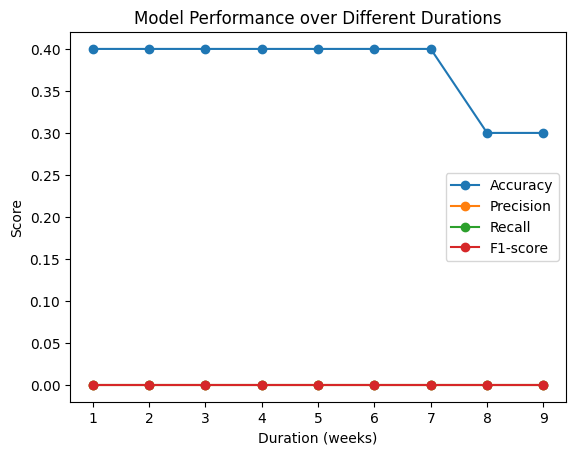

In [302]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def load_and_preprocess_data():
    """
    Load events and subscribers data, drop unnecessary columns, and handle missing values.

    Returns:
    events_data (pd.DataFrame): DataFrame containing events data.
    subscribers_data (pd.DataFrame): DataFrame containing subscribers data.
    """
    events_data = pd.read_csv('data/events_data.csv')
    subscribers_data = pd.read_csv('data/subscribers_data.csv')

    # Drop unnecessary columns
    subscribers_data = subscribers_data.drop(columns=['weeks_from_subscription_start'])

    # Handle missing values
    events_data.fillna(0, inplace=True)
    subscribers_data.fillna(0, inplace=True)

    # Convert date fields to datetime format
    events_data['dt'] = pd.to_datetime(events_data['dt'])
    subscribers_data['effective_date'] = pd.to_datetime(subscribers_data['effective_date'])

    # Sort data by date
    events_data.sort_values(by='dt', inplace=True)
    subscribers_data.sort_values(by='effective_date', inplace=True)

    return events_data, subscribers_data

def filter_events_by_date(events_data, specific_date, duration):
    """
    Filter events data based on a specific date and duration.

    Args:
    events_data (pd.DataFrame): DataFrame containing events data.
    specific_date (datetime): Specific date for filtering.
    duration (timedelta): Duration for filtering.

    Returns:
    filtered_df (pd.DataFrame): Filtered DataFrame.
    unique_members_in_week (numpy.ndarray): Unique member IDs in the specified week.
    """
    week_start = specific_date + timedelta(days=7)
    week_end = week_start + timedelta(days=6)
    unique_members_in_week = events_data[(events_data['dt'] >= week_start) & (events_data['dt'] <= week_end)]['member_id'].unique()
    filtered_df = events_data[(events_data['dt'] >= (specific_date - duration)) & (events_data['member_id'].isin(unique_members_in_week))]

    return filtered_df, unique_members_in_week

def create_result_df(filtered_df, unique_members, event_types):
    """
    Create a DataFrame with event type counts for each member.

    Args:
    filtered_df (pd.DataFrame): Filtered DataFrame.
    unique_members (numpy.ndarray): Unique member IDs.
    event_types (list): List of event types.

    Returns:
    result_df (pd.DataFrame): DataFrame with event type counts.
    """
    result_df = pd.DataFrame(index=unique_members)

    for event_type in event_types:
        event_count = filtered_df[filtered_df['event_type'] == event_type].groupby('member_id').size()
        result_df[f'{event_type}_count'] = result_df.index.map(event_count).fillna(0)

    # Calculate if a member had a pt_sale event in the last 3 months (1 for yes, 0 for no)
    pt_sale_count = filtered_df[filtered_df['event_type'] == 'pt_sale'].groupby('member_id').size()
    result_df['pt_sale'] = (result_df.index.map(pt_sale_count).fillna(0) > 0).astype(int)

    return result_df

def train_and_evaluate_model(result_df):
    """
    Train a logistic regression model and evaluate its performance.

    Args:
    result_df (pd.DataFrame): DataFrame with event type counts.

    Returns:
    model: Trained logistic regression model.
    """
    print(result_df)
    X = result_df.drop(columns=['pt_sale'])
    y = result_df['pt_sale']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

    # Choose a classification algorithm (Logistic Regression)
    model = LogisticRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Evaluate the model
    # print(classification_report(y_test, y_pred))

    return model, classification_report(y_test, y_pred)

def make_predictions(model, result_df, subscribers_data, specific_date):
    """
    Make predictions for all individuals who have not taken personal training and have a subscription.

    Args:
    model: Trained logistic regression model.
    result_df (pd.DataFrame): DataFrame with event type counts.
    subscribers_data (pd.DataFrame): DataFrame containing subscribers data.
    specific_date (datetime): Specific date for predictions.

    Returns:
    subscribers_data_for_date (pd.DataFrame): Subscribers data with predicted probabilities.
    """
    prediction_df = result_df[result_df['pt_sale'] == 0].drop(columns=['pt_sale'])
    subscribers_data_for_date = subscribers_data[subscribers_data['effective_date'] == specific_date]

    # Filter prediction_df to include only rows with member_id present in subscribers_data_for_date
    # prediction_df = prediction_df[prediction_df.index.isin(subscribers_data_for_date['member_id'])]

    if not prediction_df.empty:
        # Continue with the predictions
        prediction_df['predicted_probability'] = model.predict_proba(prediction_df)[:, 1]

        # Rank and recommend the top 10 individuals
        top_10_recommendations = prediction_df.sort_values(by='predicted_probability', ascending=False).head(10)

        # Print the top 10 recommendations
        # print("top 10 recommendations:", top_10_recommendations[['predicted_probability']])
    else:
        pass
        # print("No predictions available for the selected date.")

    # Merge the DataFrames on 'member_id' to add 'predicted_probability' to 'subscribers_data_for_date'
    subscribers_data_for_date = subscribers_data_for_date.merge(prediction_df[['predicted_probability']],
                                                                left_on='member_id', right_index=True, how='left')

    # Fill NaN values with None
    subscribers_data_for_date['predicted_probability'] = subscribers_data_for_date['predicted_probability'].where(
        subscribers_data_for_date['predicted_probability'].notna(), None)

    return subscribers_data_for_date, top_10_recommendations[['predicted_probability']]

def generate_top_10_by_segment(subscribers_data_for_date, threshold=0.5):
    """
    Generate and print top 10 recommendations for each segment.

    Args:
    subscribers_data_for_date (pd.DataFrame): Subscribers data with predicted probabilities.
    threshold (float): Threshold for considering predictions.

    Returns:
    None
    """
    sorted_dataframe = subscribers_data_for_date.sort_values(by='predicted_probability', ascending=False)
    top_10_by_segment = {}

    for segment_code in sorted_dataframe['segment_code'].unique():
        # Filter the DataFrame for the current segment_code and select the top 10 rows
        top_10_for_segment = sorted_dataframe[
            (sorted_dataframe['segment_code'] == segment_code) &
            (sorted_dataframe['predicted_probability'].notna()) &
            (sorted_dataframe['predicted_probability'] > threshold)
        ].head(10)

        # Store only the 'member_id' and 'predicted_probability' columns in the dictionary
        top_10_by_segment[segment_code] = top_10_for_segment[['member_id', 'predicted_probability']]

    # Print the top 10 members for each segment
    # for segment_code, top_10_for_segment in top_10_by_segment.items():
    #    print(f"Top 10 for segment {segment_code}:\n{top_10_for_segment}\n")


def check_success(member_id, specific_date, events_data):
    """
    Check if a member has a "pt_sale" event in a month from the specific date.

    Args:
    member_id (int): Member ID to check.
    specific_date (datetime): Specific date.
    events_data (pd.DataFrame): DataFrame containing events data.

    Returns:
    success (bool): True if success, False otherwise.
    """
    end_date = specific_date + timedelta(days=30)  # One month from the specific date
    member_events = events_data[(events_data['member_id'] == member_id) & (events_data['event_type'] == 'pt_sale')]
    success = any((member_events['dt'] >= specific_date) & (member_events['dt'] <= end_date))
    return success

def collect_results(events_data, subscribers_data, event_types, specific_date):
    durations = range(1, 10)  # Duration in weeks
    results = []
    back = None

    for duration in durations:
        duration_in_days = duration * 7  # Convert duration to days
        print("duration in days:", duration_in_days)

        filtered_df, unique_members_in_week = filter_events_by_date(events_data, specific_date, timedelta(days=duration_in_days))
        result_df = create_result_df(filtered_df, unique_members_in_week, event_types)
        print(result_df == back)

        back = result_df
        model, metric = train_and_evaluate_model(result_df)
        subscribers_data_for_date, top_10_predictions = make_predictions(model, result_df, subscribers_data, specific_date)

        top_10_predictions['success'] = False
        # Check success for each member in top 10 predictions
        for idx in top_10_predictions.index:
            top_10_predictions.loc[idx, 'success'] = check_success(idx, specific_date, events_data)
        
        y_true = top_10_predictions['success'].astype(int)
        y_pred = (top_10_predictions['predicted_probability'] > 0.5).astype(int)

        # Calculate metrics
        accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

        # Store relevant information for comparison
        results.append({
            'duration': duration,
            'model': model,
            'top_10_predictions': top_10_predictions,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    return results



def calculate_metrics(y_true, y_pred):
    """
    Calculate accuracy, precision, recall, and F1-score.

    Args:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    accuracy (float): Accuracy score.
    precision (float): Precision score.
    recall (float): Recall score.
    f1 (float): F1-score.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

def visualize_results(results):
    # Visualize the results
    durations = [result['duration'] for result in results]
    accuracy_scores = [result['accuracy'] for result in results]
    precision_scores = [result['precision'] for result in results]
    recall_scores = [result['recall'] for result in results]
    f1_scores = [result['f1'] for result in results]

    plt.plot(durations, accuracy_scores, marker='o', label='Accuracy')
    plt.plot(durations, precision_scores, marker='o', label='Precision')
    plt.plot(durations, recall_scores, marker='o', label='Recall')
    plt.plot(durations, f1_scores, marker='o', label='F1-score')

    plt.title('Model Performance over Different Durations')
    plt.xlabel('Duration (weeks)')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # parameters:
    specific_date = datetime(2019, 1, 1)
    events_data, subscribers_data = load_and_preprocess_data()
    results = collect_results(events_data, subscribers_data, event_types, specific_date)
    visualize_results(results)
